<a href="https://colab.research.google.com/github/soohwahong/RL-DQN/blob/main/RL_DQN_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
def piupepe(peepis,pepe):
    peepis = peepis + 1
    pepe = pepe + 1
    return peepis,pepe

In [6]:
peepis = 5
pepe= 4

peepis,pepe = piupepe(peepis,pepe)

print(peepis, pepe)

6 5


**Hyperparameter tuning**
* Stabalize training with increased batch_size and num_update_steps for q_network.
  * batch_size = 128
  * num_update_steps = 25

**Stabalizing Tricks**
*  Keep best network parameters
* Clipping gradients of error term to be -1.0 and 1.0

In [12]:
!pip uninstall -y numpy
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from matplotlib import pyplot as plt
import gym
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import permutations
from torch_geometric.nn import GCNConv, global_add_pool, MessagePassing, MetaLayer
from torch_geometric.data import Batch, Data, DataLoader
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.utils import scatter
import numpy as np


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# DQN-Graph

In [2]:
# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000 # eps length cap is 500
batch_size = 128
num_update_steps = 25

class ReplayBuffer:
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition

            if isinstance(s, tuple):
                s = s[0]

            # IGNORA se non hanno 4 feature
            if s.shape[0] != 4 or s_prime.shape[0] != 4:
                print(f"⚠️ Scarto transizione con shape s={s.shape}, s'={s_prime.shape}")
                continue
        
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

    def clear(self):
        self.buffer.clear()

class DQN_graph(nn.Module):
    def __init__(self, state_space=None,
                       action_space=None,
                       num_hidden_layer=2,
                       hidden_dim=None,
                       learning_rate=None):

        super(DQN_graph, self).__init__()

        # Space size check
        assert state_space is not None, "None state_space input: state_space should be assigned."
        assert action_space is not None, "None action_space input: action_space should be assigned."

        if hidden_dim is None:
            hidden_dim = state_space * 2

        self.conv1 = GCNConv(2, hidden_dim)

        # Create a list of hidden layers based on num_hidden_layer
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layer)])

        self.linear_out = nn.Linear(hidden_dim, action_space)
        self.layer_norm = LayerNorm(hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # x = global_add_pool(self.layer_norm(x), torch.LongTensor([0 for _ in range(x.size(0))]).to(x.device))
        # pooling node features into a single fixed-size feature vector that summarizes the entire graph
        # resulting tensor has one row per graph in the batch, where each row is the sum of node features for the corresponding graph.
        x = global_add_pool(self.layer_norm(x), torch.LongTensor([0 for _ in range(x.size(0))]).to(x.device))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))

        x = self.linear_out(x) # estimated Q value
        return x

    def sample_action(self, x, edge_index, epsilon):
      '''
      sample action from q network based on epsilon-greedy policy
      '''
      out = self.forward(x, edge_index)
      coin = random.random()
      if coin < epsilon:
          return random.randint(0, 1)
      else:
          return out.argmax().item()

def create_torch_graph_data(data):
  '''
  Input
    data : list of node features [position, angle, velocity, angular velocity]
  Output
    graph : torch_geometric.data.Data with x=node_feature (2), edge_index=edge_index
  '''

  if isinstance(data, tuple):
    data = data[0]

  # Ora data è un array tipo [pos, vel, angle, ang_vel]
  node_feature = [
      [data[0], data[1]],
      [data[2], data[3]],
      [data[0], data[3]],
      [data[1], data[2]],
  ]

  node_feature = torch.tensor(node_feature, dtype=torch.float)

  edge_index = []
  for i in range(4):
      for j in range(4):
          if i != j:
              edge_index.append([i, j])
  edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

  graph_data = Data(x=node_feature, edge_index=edge_index)
  return graph_data


def create_torch_graph_data_batch(batch_data):
  '''
  Input
    batch_s : tensor where each row is a state node features [position, angle, velocity, angular velocity]
  Output
    List of data_x_list, data_edge_index_list from batch of graph Data objects
  '''
  data_x = []
  data_edge_index = []

  for data in batch_data:
      data_object = create_torch_graph_data(data)
      data_x.append(data_object.x)
      data_edge_index.append(data_object.edge_index)

  return data_x, data_edge_index


def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def train(q, q_target, memory, optimizer):
  '''
  Updates q network wrt q_target network
  '''
  for _ in range(num_update_steps):
      batch_s, batch_a, batch_r, batch_s_prime, batch_done_mask = memory.sample(batch_size) # take sample of batch_size from replay buffer

      batch_s_g_x, batch_s_g_edge_index = create_torch_graph_data_batch(batch_s)
      batch_s_prime_g_x, batch_s_prime_g_edge_index = create_torch_graph_data_batch(batch_s_prime) # List of torch_geometric.data.Data with x=node_feature, edge_index=edge_index

      # Perform forward pass for both current and next state graphs
      q_out = []
      for i in range(batch_size):
        q_out_i = q(batch_s_g_x[i].to(device), batch_s_g_edge_index[i].to(device)) # get q values for all actions
        q_out.append(q_out_i.squeeze())
      q_out = torch.stack(q_out)
      q_a = q_out.gather(1, batch_a.to(device)) # get q values for actions taken

      # get q_target values for next state (by selecting action that returns max reward)
      q_target_out = []
      for i in range(batch_size):
          q_target_out_i = q_target(batch_s_prime_g_x[i].to(device), batch_s_prime_g_edge_index[i].to(device))
          q_target_out.append(q_target_out_i.squeeze())
      q_target_out = torch.stack(q_target_out)

      max_q_prime = q_target_out.max(1)[0].unsqueeze(1)

      # Compute the target Q value using the Bellman equation
      target = batch_r.to(device) + gamma * max_q_prime * batch_done_mask.to(device)

      # Compute the loss between predicted Q values and target Q values
      loss = F.smooth_l1_loss(q_a, target) # loss between predicted q_a and target q value using Huber loss function

      # Perform backpropagation and update the network
      optimizer.zero_grad()
      loss.backward()
      # Apply gradient clipping to stabalize training
      torch.nn.utils.clip_grad_norm_(q.parameters(), 1.0)
      optimizer.step()

def save_best_model(q, best_avg_score, avg_score, save_path="best_dqn_model.pth"):
  '''
  save model if avg_score is better than best_avg_score
  updates parameters of q network if best_avg_score is updated
  '''
  if avg_score > best_avg_score:
      print(f"New best avg score: {avg_score:.2f}, saving model...")
      torch.save(q.state_dict(), save_path)
      return avg_score
  return best_avg_score


training policy network!
New best avg score: 36.65, saving model...
episode 100, avg score : 36.65, eps: 7.50%
training policy network!
episode 200, avg score : 25.84, eps: 7.00%
training policy network!
training policy network!
training policy network!
training policy network!
training policy network!
training policy network!
New best avg score: 108.33, saving model...
episode 300, avg score : 108.33, eps: 6.50%
training policy network!
training policy network!
training policy network!
training policy network!
training policy network!
episode 400, avg score : 103.31, eps: 6.00%


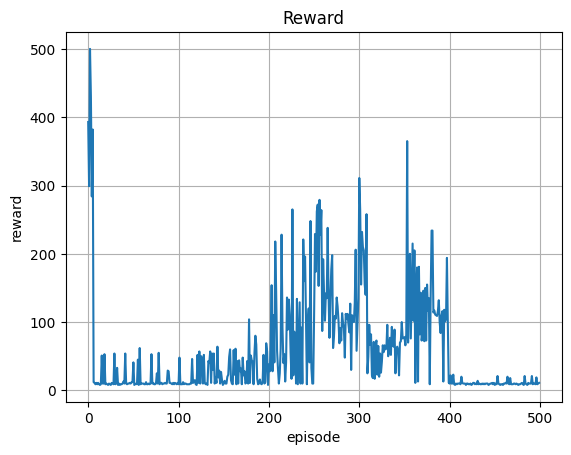

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1')

seed = 20
# np.random.seed(seed)
random.seed(seed)
seed_torch(seed)
env.action_space.seed(seed)
# set parameters
episodes = 500
learning_rate = 0.0005
target_update_interval = 100 # number of episodes
train_interval = 2000 # size of memory buffer

q = DQN_graph(state_space=env.observation_space.shape[0],
                action_space=env.action_space.n,
                num_hidden_layer=1,
                hidden_dim=128,
                learning_rate=learning_rate).to(device)
q_target = DQN_graph(state_space=env.observation_space.shape[0],
                        action_space=env.action_space.n,
                        num_hidden_layer=1,
                        hidden_dim=128,
                        learning_rate=learning_rate).to(device)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

score = 0.0
score_list = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)
best_avg_score = float('-inf')

for n_epi in range(episodes):
    epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))  # Linear annealing from 8% to 1%
    # Reset the environment
    observation = env.reset()
    # print(f'observation at reset : {observation}')
    s = observation
    done = False

    while not done:
        s_g = create_torch_graph_data(s)

        a = q.sample_action(s_g.x.to(device), s_g.edge_index.to(device), epsilon)
        s_prime, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        done_mask = 0.0 if done else 1.0
        memory.put((s, a, r / 100.0, s_prime, done_mask))
        s = s_prime

        score += r

        if done:
            break


    # only update target network at update intervals to prevent oscillation
    if n_epi % target_update_interval == 0 and n_epi != 0:
        avg_score = sum(score_list[-target_update_interval:])/target_update_interval
        best_avg_score = save_best_model(q, best_avg_score, avg_score) # update q network parameters if best_avg_score is updated
        print(f"episode {n_epi}, avg score : {avg_score:.2f}, eps: {epsilon * 100:.2f}%")
        q_target.load_state_dict(q.state_dict())

    # train q network wrt target network at train intervals
    if memory.size() > train_interval:
        print(f'training policy network!')
        train(q, q_target, memory, optimizer)
        memory.clear()

    # rewards +1 for every step taken, threshold is 475
    score_list.append(score)
    score = 0.0

env.close()

plt.plot(score_list)
plt.title('Reward')
plt.ylabel('reward')
plt.xlabel('episode')
plt.grid()
plt.show()

In [6]:
def print_model_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()  # Number of elements in the parameter tensor
            total_params += param_count
            print(f"{name}: {param.size()}, {param_count} elements")

    print(f"Total number of parameters: {total_params}")

# Example usage:
# Assuming `model` is your PyTorch model
print_model_parameters(q)

conv1.bias: torch.Size([128]), 128 elements
conv1.lin.weight: torch.Size([128, 2]), 256 elements
hidden_layers.0.weight: torch.Size([128, 128]), 16384 elements
hidden_layers.0.bias: torch.Size([128]), 128 elements
linear_out.weight: torch.Size([2, 128]), 256 elements
linear_out.bias: torch.Size([2]), 2 elements
layer_norm.weight: torch.Size([128]), 128 elements
layer_norm.bias: torch.Size([128]), 128 elements
Total number of parameters: 17410


### DQN has "catastrophic forgetting" in which performance can drop after period of learning.

- [x] Implement stale network parameters
- [x] Clipping gradients of error term to be -1.0 and 1.0

For example, in Breakout, the DQN agent may reach a point of averaging a high score over 400, and then, after another large batch of learning, it might be averaging a score of only around 200. The solution Mnih et al. [2015] propose to this problem is to simply save the network parameters that resulted in the best test performance.

One of the reasons this forgetting occurs is the inherent instability of approximating the Q-function over a large state-space using these Bellman updates. One of the main contributions of Mnih et al. [2015] was fighting this instability using experience replay and stale network parameters, as mentioned above. Additionally, Mnih et al. [2015] found that clipping the gradient of the error term to be between −1.0 and 1.0 further improved the stability of the algorithm by not allowing any single mini-batch update to change the parameters drastically.

Another reason this catastrophic forgetting occurs is that the algorithm is learning a proxy, the Q-values, for a policy instead of approximating the policy directly. A side effect of this method of policy generation is a learning update could increase the accuracy of a Q-function approximator, while decreasing the performance of the resulting policy.

Furthermore Q-values for different actions of the same state can be very similar if any of these actions does not have a significant effect on near-term reward. These small differences are the result of longer-term rewards and are therefore critical to the optimal policy. The consequence of trying to learn an approximator for this type of function is that very small errors in the Q-values can result is very different policies, making it difficult to learn long-term policies.







In [3]:
import wntr

# Caricare il modello da un file .inp
wn = wntr.network.WaterNetworkModel(r'C:\Users\nephr\Desktop\Uni Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp')

In [74]:
# Prendi un esempio di nodo e di arco
junc = next(iter(wn.junctions()))[1]
pipe = next(iter(wn.pipes()))[1]

# Lista attributi disponibili
print("Proprietà disponibili per un nodo (Junction):")
print(sorted(junc.__dict__.keys()))

print("\nProprietà disponibili per un arco (Pipe):")
print(sorted(pipe.__dict__.keys()))

Proprietà disponibili per un nodo (Junction):
['_controls', '_coordinates', '_curve_reg', '_demand', '_demand_timeseries_list', '_elevation', '_emitter_coefficient', '_head', '_initial_quality', '_is_isolated', '_leak', '_leak_area', '_leak_demand', '_leak_discharge_coeff', '_leak_end_control_name', '_leak_start_control_name', '_leak_status', '_link_reg', '_minimum_pressure', '_name', '_node_reg', '_options', '_pattern_reg', '_pressure', '_pressure_exponent', '_quality', '_required_pressure', '_source', '_tag']

Proprietà disponibili per un arco (Pipe):
['_bulk_coeff', '_check_valve', '_controls', '_curve_reg', '_diameter', '_end_node', '_flow', '_friction_factor', '_headloss', '_initial_quality', '_initial_setting', '_initial_status', '_internal_status', '_is_isolated', '_length', '_link_name', '_link_reg', '_minor_loss', '_node_reg', '_options', '_pattern_reg', '_prev_setting', '_quality', '_reaction_rate', '_roughness', '_setting', '_start_node', '_tag', '_user_status', '_velocity',

In [7]:

import os
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import NNConv, global_mean_pool


@dataclass
class GraphFeatureConfig:
    node_features: Tuple[str, ...] = ("elevation", "demand", "pressure", "leak_demand")
    edge_features: Tuple[str, ...] = ("length", "diameter", "flowrate", "headloss")
    include_only_junctions: bool = True   # If True, nodes = junctions only; else include tanks/reservoirs with zeros for missing feats
    undirected: bool = True               # If True, we add reverse edges to make the graph undirected


# -------------------------
# WNTR → torch_geometric
# -------------------------

def run_wntr_simulation(inp_path: str, simulation_duration: Optional[int] = None, timestep_index: int = -1):
    """
    Load a WNTR WaterNetworkModel from an EPANET INP file, run a hydraulic simulation,
    and return (wn, results, timestep_index_resolved). If simulation_duration is provided,
    it will override the duration in the INP for the run.
    """
    import wntr  # Local import to avoid environment import errors when this module is imported elsewhere

    if not os.path.exists(inp_path):
        raise FileNotFoundError(f"INP file not found: {inp_path}")

    wn = wntr.network.WaterNetworkModel(inp_path)

    # Optionally override simulation duration (in seconds)
    if simulation_duration is not None:
        wn.options.time.duration = simulation_duration

    sim = wntr.sim.WNTRSimulator(wn)
    results = sim.run_sim()

    # Determine timestep index
    time_index = results.time # pandas Index of times in seconds
    if len(time_index) == 0:
        raise RuntimeError("Simulation produced no time steps.")
    if timestep_index < 0:
        timestep_index = len(time_index) - 1  # last timestep by default
    if timestep_index >= len(time_index):
        raise IndexError(f"timestep_index {timestep_index} out of range (0..{len(time_index)-1})")

    return wn, results, timestep_index


def build_pyg_from_wntr(
    wn,
    results,
    timestep_index: int,
    cfg: GraphFeatureConfig = GraphFeatureConfig(),
) -> Tuple[Data, Dict[str, int], Dict[int, str], Dict[str, int], Dict[int, str]]:
    """
    Convert a WNTR network + results (at a given timestep index) to a torch_geometric Data object.

    Node features (x): [elevation, demand, pressure, leak_demand]
    Edge features (edge_attr): [length, diameter, flowrate, headloss]

    Returns:
        data: torch_geometric.data.Data
        node2idx, idx2node: mappings for nodes
        edge2idx, idx2edge: mappings for edges (by pipe name)
    """
    import numpy as np
    import pandas as pd

    # Collect nodes
    node_names: List[str] = []
    if cfg.include_only_junctions:
        node_names = list(wn.junction_name_list)
    else:
        # Optionally include tanks/reservoirs
        node_names = list(wn.node_name_list)

    node2idx = {name: i for i, name in enumerate(node_names)}
    idx2node = {i: name for name, i in node2idx.items()}

    # Prepare node feature containers
    elev = []
    demand = []
    pressure = []
    leak_dem = []

    # Results tables
    # results.node is a dict-like with DataFrames keyed by variable name
    df_demand: Optional[pd.DataFrame] = results.node.get("demand", None)
    df_pressure: Optional[pd.DataFrame] = results.node.get("pressure", None)
    df_leak: Optional[pd.DataFrame] = results.node.get("leak_demand", None)

    for name in node_names:
        n = wn.get_node(name)

        # Elevation
        e = getattr(n, "elevation", 0.0)
        elev.append(float(e))

        # Demand, Pressure, Leak Demand at timestep
        d = 0.0
        p = 0.0
        l = 0.0
        if df_demand is not None and name in df_demand.columns:
            d = float(df_demand.iloc[timestep_index][name])
        if df_pressure is not None and name in df_pressure.columns:
            p = float(df_pressure.iloc[timestep_index][name])
        if df_leak is not None and name in df_leak.columns:
            l = float(df_leak.iloc[timestep_index][name])

        demand.append(d)
        pressure.append(p)
        leak_dem.append(l)

    x = np.stack([elev, demand, pressure, leak_dem], axis=1)  # (N, 4)

    # Collect edges (pipes only by default)
    edge_index_list: List[Tuple[int, int]] = []
    edge_attrs: List[List[float]] = []
    edge_names: List[str] = []

    # Link results
    df_flow = results.link.get("flowrate", None)
    df_headloss = results.link.get("headloss", None)

    for pipe_name in wn.pipe_name_list:
        pipe = wn.get_link(pipe_name)

        u_name = pipe.start_node_name
        v_name = pipe.end_node_name
        if u_name not in node2idx or v_name not in node2idx:
            # Skip edges whose endpoints are not in our node set
            continue

        u = node2idx[u_name]
        v = node2idx[v_name]

        length = float(getattr(pipe, "length", 0.0))
        diameter = float(getattr(pipe, "diameter", 0.0))

        flow = 0.0
        headloss = 0.0
        if df_flow is not None and pipe_name in df_flow.columns:
            flow = float(df_flow.iloc[timestep_index][pipe_name])
        if df_headloss is not None and pipe_name in df_headloss.columns:
            headloss = float(df_headloss.iloc[timestep_index][pipe_name])

        # Add (u,v)
        edge_index_list.append((u, v))
        edge_attrs.append([length, diameter, flow, headloss])
        edge_names.append(pipe_name)

        # If undirected, add (v,u) with same attributes
        if cfg.undirected:
            edge_index_list.append((v, u))
            edge_attrs.append([length, diameter, flow, headloss])
            edge_names.append(f"{pipe_name}__rev" )

    import numpy as np
    edge_index = np.array(edge_index_list, dtype=np.int64).T  # (2, E)
    edge_attr = np.array(edge_attrs, dtype=np.float32)        # (E, 4)

    # Convert to torch tensors
    x = torch.tensor(x, dtype=torch.float32)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.num_nodes = x.shape[0]

    edge2idx = {name: i for i, name in enumerate(edge_names)}
    idx2edge = {i: name for name, i in edge2idx.items()}

    return data, node2idx, idx2node, edge2idx, idx2edge


# -------------------------
# GNN Encoder + DQN Head
# -------------------------

class EdgeAwareGNN(nn.Module):
    """
    Edge-aware GNN using NNConv layers so that edge attributes influence message passing.
    - Node input dim: 4 (elevation, demand, pressure, leak_demand)
    - Edge input dim: 4 (length, diameter, flowrate, headloss)
    """
    def __init__(self, node_in: int = 4, edge_in: int = 4, hidden: int = 64, num_layers: int = 2, dropout: float = 0.0):
        super().__init__()
        self.node_in = node_in
        self.edge_in = edge_in
        self.hidden = hidden
        self.num_layers = num_layers

        layers = []
        # First NNConv: node_in -> hidden
        edge_nn1 = nn.Sequential(
            nn.Linear(edge_in, 64),
            nn.ReLU(),
            nn.Linear(64, node_in * hidden),
        )
        conv1 = NNConv(in_channels=node_in, out_channels=hidden, nn=edge_nn1, aggr='mean')
        layers.append(conv1)

        for _ in range(num_layers - 1):
            edge_nn = nn.Sequential(
                nn.Linear(edge_in, 128),
                nn.ReLU(),
                nn.Linear(128, hidden * hidden),
            )
            conv = NNConv(in_channels=hidden, out_channels=hidden, nn=edge_nn, aggr='mean')
            layers.append(conv)

        self.convs = nn.ModuleList(layers)
        self.act = nn.ReLU()
        self.norms = nn.ModuleList([nn.LayerNorm(hidden) for _ in range(len(layers))])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr, batch=None):
        h = x
        for conv, ln in zip(self.convs, self.norms):
            h = conv(h, edge_index, edge_attr)
            h = self.act(h)
            h = ln(h)
            h = self.dropout(h)

        if batch is None:
            # Single-graph case: create a zero batch assignment
            batch = torch.zeros(h.size(0), dtype=torch.long, device=h.device)

        g = global_mean_pool(h, batch)  # (B, hidden)
        return h, g  # node embeddings, graph embedding


class DQNGNN(nn.Module):
    """
    DQN-style head on top of the EdgeAwareGNN encoder.
    Produces Q-values for a given discrete action space.
    """
    def __init__(self, action_dim: int, node_in: int = 4, edge_in: int = 4, hidden: int = 64, num_layers: int = 2, dropout: float = 0.0):
        super().__init__()
        self.encoder = EdgeAwareGNN(node_in=node_in, edge_in=edge_in, hidden=hidden, num_layers=num_layers, dropout=dropout)
        self.q_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden),
            nn.Linear(hidden, action_dim),
        )

    def forward(self, data: Data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = getattr(data, "batch", None)
        _, g = self.encoder(x, edge_index, edge_attr, batch)
        q = self.q_head(g)  # (B, action_dim)
        return q


# -------------------------
# Example usage
# -------------------------

def example_build_and_forward(inp_path: str, action_dim: int = 8, timestep_index: int = -1):
    """
    Build the Net3 graph with features and run a forward pass through DQNGNN.
    Returns (data, q_values).
    """
    wn, results, t_idx = run_wntr_simulation(inp_path, timestep_index=timestep_index)
    data, node2idx, idx2node, edge2idx, idx2edge = build_pyg_from_wntr(wn, results, t_idx)

    model = DQNGNN(action_dim=action_dim, node_in=4, edge_in=4, hidden=64, num_layers=2, dropout=0.1)
    q = model(data)  # (1, action_dim) if single graph
    return data, q


In [9]:

path = r"C:\Users\nephr\Desktop\Uni-Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp"

data, q = example_build_and_forward(path, action_dim=10, timestep_index=-1)
print(data)
print("Q-values shape:", q)



Data(x=[92, 4], edge_index=[2, 226], edge_attr=[226, 4], num_nodes=92)
Q-values shape: tensor([[-0.5044, -0.3079, -0.7156, -0.8863, -0.6756,  0.1125, -0.9567,  0.3025,
          0.3131, -0.3311]], grad_fn=<AddmmBackward0>)


Stato attuale

✅ Grafo creato: sì. La Net3 è stata trasformata in un grafo torch_geometric.Data con le feature che hai scelto (nodi: elevation, demand, pressure, leak_demand; archi: length, diameter, flowrate, headloss).

✅ Encodato dalla GNN: sì. La classe EdgeAwareGNN elabora il grafo, e nel path example_build_and_forward viene effettivamente chiamata: produciamo un embedding globale del grafo (via global_mean_pool).

✅ Q-values generati: sì. DQNGNN riceve l’embedding e produce i Q-values di dimensione action_dim (es. torch.Size([1, 10])).

⛔ Azioni concrete non ancora definite: al momento i 10 output sono slot astratti. Non abbiamo ancora mappato “azione i” → “apri/chiudi valvola X”, “+/- setpoint pompa Y”, ecc.

⛔ Ambiente RL & training: non c’è ancora un Gym-like env per:

applicare un’azione al modello WNTR,

rieseguire la simulazione,

calcolare reward e next state,

aggiornare la replay buffer e fare training DQN.

Quindi abbiamo forward inference (Q-values), ma non la loop di addestramento/interazione.

In [6]:
# ============================================================
# DQN + GNN su WNTR (Net3)
# - Stato: grafo torch_geometric con feature scelte da te
# - Modello: DQNGNN (EdgeAwareGNN + head) dal modulo wntr_gnn_rl
# - Azioni (di default): do_nothing, pump_up, pump_down, toggle su 3 valvole
# - Reward: penalità per sotto-pressione, perdite e headloss totali
# ============================================================

import os
import random
import collections
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch_geometric.data import Batch

# ====== importa le utilità dal modulo che abbiamo creato prima ======
# Assumo che wntr_gnn_rl.py sia nello stesso folder o nel PYTHONPATH

# ============================================================
# Hyperparameters
# ============================================================

learning_rate = 5e-4
gamma = 0.98
buffer_limit = 50_000
batch_size = 128
num_update_steps = 25

target_update_every_episodes = 50
max_episodes = 300
max_steps_per_episode = 10  # episodio a lunghezza fissa (puoi aumentare)
epsilon_start = 0.10
epsilon_end = 0.02
epsilon_decay_episodes = 200  # decresce linearmente su 200 ep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# Reward (semplice e composito)
# ============================================================

def compute_reward(results, t_idx, p_min=20.0, w_underP=1.0, w_leak=1.0, w_headloss=0.01):
    """
    Reward negativo di penalità:
      - underP: somma degli shortfall sotto soglia p_min
      - leak:   somma dei leak_demand (se presenti)
      - headloss: somma assoluta headloss (proxy costo)
    """
    p = results.node["pressure"].iloc[t_idx]
    underP = np.maximum(0.0, p_min - p.values).sum()

    leak_df = results.node.get("leak_demand", None)
    leak_sum = float(leak_df.iloc[t_idx].sum()) if leak_df is not None else 0.0

    hl = results.link.get("headloss", None)
    headloss_sum = float(np.abs(hl.iloc[t_idx].values).sum()) if hl is not None else 0.0

    reward = -(w_underP * underP + w_leak * leak_sum + w_headloss * headloss_sum)
    return float(reward)


# ============================================================
# Azioni (auto-selezione attuatori da Net3)
# ============================================================

@dataclass
class Actuators:
    pump_names: List[str]
    valve_names: List[str]

    @property
    def labels(self) -> List[str]:
        labels = ["do_nothing"]
        if self.pump_names:
            labels += ["pump_up", "pump_down"]
        # fino a 3 valvole toggle
        for i, v in enumerate(self.valve_names[:3]):
            labels.append(f"valve_{v}_toggle")
        return labels


def pick_actuators(wn, max_valves=3) -> Actuators:
    pump_names = list(getattr(wn, "pump_name_list", []))
    valve_names = list(getattr(wn, "valve_name_list", []))
    # tieni al massimo N valvole per semplicità
    valve_names = valve_names[:max_valves]
    return Actuators(pump_names=pump_names[:1], valve_names=valve_names)


def apply_action_inplace(wn, action_id: int, acts: Actuators, pump_speed_step=0.05):
    """
    Applica un'azione discreta al modello WNTR *in-place*.

    0: do_nothing
    1: pump_up   (se c'è almeno 1 pump)
    2: pump_down (se c'è almeno 1 pump)
    3..: toggle valvole selezionate (OPEN <-> CLOSED)

    Nota: semplice/sicuro. Migliorabile con PRV setpoint, TCV setting, ecc.
    """
    import wntr
    from wntr.network.base import LinkStatus

    if action_id == 0:
        return "do_nothing"

    idx = 1
    # pump controls (solo la prima pompa)
    if acts.pump_names:
        pump_name = acts.pump_names[0]
        pump = wn.get_link(pump_name)
        if action_id == idx:
            # pump_up
            new_speed = float(getattr(pump, "speed", 1.0)) + pump_speed_step
            pump.speed = max(0.2, min(2.0, new_speed))
            return f"pump_up({pump_name}) -> speed={pump.speed:.2f}"
        idx += 1
        if action_id == idx:
            # pump_down
            new_speed = float(getattr(pump, "speed", 1.0)) - pump_speed_step
            pump.speed = max(0.2, min(2.0, new_speed))
            return f"pump_down({pump_name}) -> speed={pump.speed:.2f}"
        idx += 1

    # valve toggles
    for vname in acts.valve_names:
        if action_id == idx:
            v = wn.get_link(vname)
            # toggla lo status
            if v.status == LinkStatus.Open:
                v.status = LinkStatus.Closed
                return f"valve_toggle({vname}) -> CLOSED"
            else:
                v.status = LinkStatus.Open
                return f"valve_toggle({vname}) -> OPEN"
        idx += 1

    # azione fuori range → niente
    return "noop_out_of_range"


# ============================================================
# Env minimale per WNTR (episodio a passi fissi)
# ============================================================

class WNTRGraphEnv:
    def __init__(self, inp_path: str, include_only_junctions=True, undirected=True, timestep_index=-1):
        self.inp_path = inp_path
        self.include_only_junctions = include_only_junctions
        self.undirected = undirected
        self.timestep_index = timestep_index

        self.wn = None
        self.results = None
        self.t_idx = None
        self.cfg = GraphFeatureConfig(include_only_junctions=include_only_junctions, undirected=undirected)

        # riempi al reset
        self.acts: Optional[Actuators] = None
        self.action_labels: List[str] = []

    def reset(self):
        # ricarica "pulito"
        self.wn, self.results, self.t_idx = run_wntr_simulation(self.inp_path, timestep_index=self.timestep_index)
        # scegli attuatori
        self.acts = pick_actuators(self.wn, max_valves=3)
        self.action_labels = self.acts.labels
        # stato iniziale (grafo)
        data, *_ = build_pyg_from_wntr(self.wn, self.results, self.t_idx, cfg=self.cfg)
        # nessun terminal
        return data, 0.0, False, {"action": "reset", "labels": self.action_labels}

    def step(self, action_id: int):
        # applica azione sul modello corrente
        note = apply_action_inplace(self.wn, action_id, self.acts)

        # rilancia simulazione
        sim_wn, sim_results, t_idx = run_wntr_simulation(self.inp_path, timestep_index=self.timestep_index)
        # Copia le modifiche di stato (pompe/valvole) dal wn corrente a sim_wn prima di simulare:
        # — per semplicità ri-applichiamo la stessa azione su sim_wn
        _ = apply_action_inplace(sim_wn, action_id, self.acts)

        sim = sim_results  # già simulato da run_wntr_simulation(sim_wn)
        # NB: sopra abbiamo ri-eseguito run_wntr_simulation su file "pulito", poi ri-applicato l'azione.
        #     Se vuoi performance migliori, puoi mantenere un wn "vivo" e simulare direttamente con EPANETToolkit.

        # costruisci nuovo grafo
        data_prime, *_ = build_pyg_from_wntr(sim_wn, sim, t_idx, cfg=self.cfg)
        # reward
        r = compute_reward(sim, t_idx)

        # done: tienilo False (episodi a passi fissi)
        done = False
        return data_prime, r, done, {"action": note}


# ============================================================
# Replay Buffer per grafi (memorizza torch_geometric.Data)
# ============================================================

class ReplayBuffer:
    def __init__(self, capacity=buffer_limit):
        self.buffer = collections.deque(maxlen=capacity)

    def put(self, transition):
        # transition: (Data_s, int_a, float_r, Data_s_prime, done_mask)
        self.buffer.append(transition)

    def size(self):
        return len(self.buffer)

    def clear(self):
        self.buffer.clear()

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_list, a_list, r_list, sp_list, dm_list = [], [], [], [], []
        for (s, a, r, s_prime, done_mask) in mini_batch:
            s_list.append(s)
            sp_list.append(s_prime)
            a_list.append([a])
            r_list.append([r])
            dm_list.append([done_mask])
        batch_s = Batch.from_data_list(s_list)
        batch_sp = Batch.from_data_list(sp_list)
        a = torch.tensor(a_list, dtype=torch.long)
        r = torch.tensor(r_list, dtype=torch.float32)
        dm = torch.tensor(dm_list, dtype=torch.float32)  # 1.0 se NON terminale, 0.0 se terminale
        return batch_s, a, r, batch_sp, dm


# ============================================================
# Funzioni utili
# ============================================================

def epsilon_by_episode(ep):
    if ep >= epsilon_decay_episodes:
        return epsilon_end
    # lineare
    return epsilon_start + (epsilon_end - epsilon_start) * (ep / epsilon_decay_episodes)


def sample_action(model: nn.Module, state_data: Batch, epsilon: float, action_dim: int) -> int:
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    with torch.no_grad():
        q_vals = model(state_data.to(device))
        # q_vals shape: [B, action_dim]; B=1
        return int(q_vals.argmax(dim=1).item())


# ============================================================
# Train step (batchificato) — simile al tuo, ma per grafi
# ============================================================

def train_step(q_net, q_tgt, memory: ReplayBuffer, optimizer: optim.Optimizer):
    q_net.train()
    for _ in range(num_update_steps):
        batch_s, batch_a, batch_r, batch_sp, batch_dm = memory.sample(batch_size)

        batch_s = batch_s.to(device)
        batch_sp = batch_sp.to(device)
        batch_a = batch_a.to(device)
        batch_r = batch_r.to(device)
        batch_dm = batch_dm.to(device)

        # Q(s, a)
        q_out = q_net(batch_s)                  # [B, A]
        q_a = q_out.gather(1, batch_a)         # [B, 1]

        # max_a' Q_target(s', a')
        with torch.no_grad():
            q_tgt_out = q_tgt(batch_sp)        # [B, A]
            max_qp = q_tgt_out.max(dim=1, keepdim=True)[0]  # [B,1]

        target = batch_r + gamma * max_qp * batch_dm  # Bellman
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
        optimizer.step()


# ============================================================
# Main di esempio
# ============================================================

def main():
    NET3_PATH = r"C:\Users\nephr\Desktop\Uni Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp"
    assert os.path.exists(NET3_PATH), f"File non trovato: {NET3_PATH}"

    env = WNTRGraphEnv(NET3_PATH, include_only_junctions=True, undirected=True, timestep_index=-1)

    # Stato iniziale
    s, _, _, info = env.reset()
    action_labels = info["labels"]
    action_dim = len(action_labels)
    print("ACTIONS:", action_labels)

    # Modello
    q = DQNGNN(action_dim=action_dim, node_in=4, edge_in=4, hidden=64, num_layers=2, dropout=0.1).to(device)
    q_tgt = DQNGNN(action_dim=action_dim, node_in=4, edge_in=4, hidden=64, num_layers=2, dropout=0.1).to(device)
    q_tgt.load_state_dict(q.state_dict())

    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    memory = ReplayBuffer(buffer_limit)

    best_avg = -1e9
    scores = []

    for ep in range(1, max_episodes + 1):
        s, _, _, _ = env.reset()
        score = 0.0
        eps = epsilon_by_episode(ep)

        for t in range(max_steps_per_episode):
            # Batch "finto" di taglia 1 per passare a DQNGNN
            s_batch = Batch.from_data_list([s]).to(device)
            a = sample_action(q, s_batch, eps, action_dim)

            sp, r, done, step_info = env.step(a)

            # done_mask: 0.0 se terminale; qui usiamo episodi a durata fissa
            done_mask = 0.0 if done else 1.0
            memory.put((s, a, r, sp, done_mask))
            s = sp
            score += r

            if memory.size() >= 2 * batch_size:
                train_step(q, q_tgt, memory, optimizer)

            if done:
                break

        scores.append(score)

        # target update periodico
        if ep % target_update_every_episodes == 0:
            q_tgt.load_state_dict(q.state_dict())

        avg = np.mean(scores[-20:])  # media mobile
        print(f"[Ep {ep:03d}] eps={eps:.3f} score={score:.2f} avg20={avg:.2f}")

        # salva best
        if avg > best_avg:
            best_avg = avg
            torch.save(q.state_dict(), "best_dqn_wntr.pth")

    print("Training finito. Miglior media (ultimi 20):", best_avg)


if __name__ == "__main__":
    main()


NameError: name 'GraphFeatureConfig' is not defined